<a href="https://colab.research.google.com/github/sanjok100/Adaptive-anomaly-detection-using-AI-ML-in-5G-IOT/blob/main/5G_NIDD_AdaptiveAnomalyLevel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP for 5G-NIDD Dataset (Google Colab)
This notebook demonstrates an anomaly detection pipeline using an MLP neural network model on the 5G-NIDD dataset.

In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Path to your CSV in Drive
file_path = '/content/drive/MyDrive/Combined.csv'

# Read the CSV
data = pd.read_csv(file_path)

# Display first few rows
data.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-3769801323.py:11: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


,Unnamed: 0,Seq,Dur,RunTime,Mean,Sum,Min,Max,Proto,sTos,...,sVid,dVid,SrcTCPBase,DstTCPBase,TcpRtt,SynAck,AckDat,Label,Attack Type,Attack Tool
0,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,icmp,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Benign,Benign,Benign
1,1,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,icmp,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Benign,Benign,Benign
2,2,3,4.998020,4.998020,4.998020,4.998020,4.998020,4.998020,udp,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Benign,Benign,Benign
3,3,4,4.998037,4.998037,4.998037,4.998037,4.998037,4.998037,udp,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Benign,Benign,Benign
4,4,5,4.999453,4.999453,4.999453,4.999453,4.999453,4.999453,udp,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Benign,Benign,Benign


In [ ]:
!pip install -U tensorflow scikit-learn==1.4.2 scikeras matplotlib seaborn
!pip install river


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf

In [ ]:
# Handle missing values
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].fillna(data[col].mode()[0])
    else:
        data[col] = data[col].fillna(data[col].median())

# Encode categorical columns
data = pd.get_dummies(data, columns=['Proto', 'State','Cause','sDSb','dDSb'], drop_first=True)

In [ ]:
data['binary_label'] = data['Label'].apply(lambda x: 0 if x == 'Benign' else 1)

In [ ]:
print(data['binary_label'].value_counts())

binary_label
1    738153
0    477737
Name: count, dtype: int64


In [ ]:
X=data.drop(['Label','binary_label','Attack Type', 'Attack Tool','Unnamed: 0'],axis=1,errors='ignore')
y=data['binary_label']

# Compute ANOVA F-score
f_scores, p_values = f_classif(X, y)

# Create a readable table
anova_results = pd.DataFrame({
    "Feature": X.columns,
    "F-Score": f_scores,
    "P-Value": p_values
})

anova_results = anova_results.sort_values(by="F-Score", ascending=False)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [36 37] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [ ]:
print("ANOVA selected features:", anova_results)

ANOVA selected features:       Feature        F-Score   P-Value
0         Seq  469849.639067  0.000000
19     Offset  319314.409720  0.000000
9        sTtl  271783.716581  0.000000
48  Proto_tcp  203833.922817  0.000000
42     AckDat  114843.308858  0.000000
..        ...            ...       ...
64    sDSb_54       1.545104  0.213860
76   dDSb_cs4       1.545104  0.213860
30     DstGap       0.900303  0.342701
36       sVid            NaN       NaN
37       dVid            NaN       NaN

[78 rows x 3 columns]


In [ ]:
#Apply ANOVA to Select TOP 10 Features
selector = SelectKBest(score_func=f_classif, k=10)
X_anova = selector.fit_transform(X, y)

#Get the Names of Selected Features
selected_indices = selector.get_support(indices=True)
top_10_features = X.columns[selected_indices]

print(" Top 10 Features from ANOVA:")
print(top_10_features)


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [36 37] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


 Top 10 Features from ANOVA:
Index(['Seq', 'sTtl', 'Offset', 'TcpRtt', 'AckDat', 'Proto_icmp', 'Proto_tcp',
       'Proto_udp', 'State_INT', 'State_RST'],
      dtype='object')


In [ ]:
X = X[top_10_features]


In [ ]:
anova_scores = pd.DataFrame({
    "Feature": X.columns,
    "F_Score": selector.scores_[selected_indices],
    "p_value": selector.pvalues_[selected_indices]
})

anova_scores = anova_scores.sort_values(by="F_Score", ascending=False)
print(anova_scores.head(10))

      Feature        F_Score  p_value
0         Seq  469849.639067      0.0
2      Offset  319314.409720      0.0
1        sTtl  271783.716581      0.0
6   Proto_tcp  203833.922817      0.0
4      AckDat  114843.308858      0.0
7   Proto_udp  110850.749473      0.0
9   State_RST   50539.541491      0.0
8   State_INT   48708.607313      0.0
3      TcpRtt   48169.832384      0.0
5  Proto_icmp   42247.649004      0.0


In [ ]:
#train/test/validate
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=1/9, stratify=y_temp, random_state=42
)

In [ ]:
#balance and scale for tuning
df_train = pd.concat([X_train, y_train], axis=1)
benign = df_train[df_train['binary_label'] == 0]
attack = df_train[df_train['binary_label'] == 1]

if len(benign) > len(attack):
    attack_up = resample(attack, replace=True, n_samples=len(benign), random_state=42)
    df_bal = pd.concat([benign, attack_up])
else:
    benign_up = resample(benign, replace=True, n_samples=len(attack), random_state=42)
    df_bal = pd.concat([benign_up, attack])

X_bal = df_bal.drop('binary_label', axis=1)
y_bal = df_bal['binary_label']

#Normalize
scaler = StandardScaler()
X_bal = scaler.fit_transform(X_bal)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
#define model builder
def create_model(optimizer='adam', lr=0.001, dropout_rate=0.3):
    model = Sequential()
    model.add(tf.keras.Input(shape=(X_train.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    if optimizer == 'adam':
        opt = Adam(learning_rate=lr)
    else:
        opt = RMSprop(learning_rate=lr)

    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
!pip install keras-tuner

In [ ]:
# GRID SEARCH + K-FOLD
# Wrap model
keras_clf = KerasClassifier(model=create_model, verbose=0)

# Define parameter grid
param_grid = {
    "model__optimizer": ["adam", "rmsprop"],
    "model__lr": [0.001, 0.0005],
    "model__dropout_rate": [0.2, 0.3],
    "batch_size": [64, 128],
    "epochs": [5]
}

# K-Fold setup (5-fold)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Early stopping callback
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Grid search
grid = GridSearchCV(
    estimator=keras_clf,
    param_grid=param_grid,
    cv=kfold,
    n_jobs=-1,
    verbose=2
)

# Fit grid search
grid_result = grid.fit(X_bal, y_bal, callbacks=[es], validation_data=(X_val, y_val))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
#adaptive confidence threshold
from river.drift import ADWIN

def adaptive_threshold(confidences, window=300, k=1.5):
    #Dynamic threshold based on recent prediction confidence
    if len(confidences) < window:
        return 0.5
    recent = confidences[-window:]
    return np.mean(recent) - k * np.std(recent)


In [ ]:
from collections import deque

#Pick best and evaluate on test set
print("\nBest Parameters:", grid_result.best_params_)
print("Best Cross-Validation Accuracy:", grid_result.best_score_)

best_model = grid_result.best_estimator_

# ADWIN drift detector to monitor prediction error over time
drift_detector = ADWIN()

# Sliding window to store recent prediction probabilities
# Used for adaptive threshold calculation
prob_window = deque(maxlen=300)

# Buffers to store feedback data for possible retraining
X_feedback = []
y_feedback = []

# Lists to store adaptive predictions and probabilities
y_pred_adaptive = []
y_probs_all = []

# Convert y_test to numpy for indexing safety
y_test_np = y_test.values

# Predict probabilities for the entire test set (binary class probability)
y_probs = best_model.predict_proba(X_test)[:, 1]

def adaptive_decision(prob, prob_window, min_theta=0.5, k=1.5):
     """
    Computes a dynamic decision threshold based on
    recent probability distribution. If insufficient history (<50 samples), use default threshold.
    Otherwise, adapt threshold using mean - k*std of recent window.
    """
    if len(prob_window) < 50:
        theta = min_theta
    else:
        theta = max(min_theta,
                    np.mean(prob_window) - k * np.std(prob_window))
    return 1 if prob >= theta else 0, theta

# Prevent too frequent retraining
last_retrain = -1000
retrain_gap = 1000

# Adaptive prediction loop
for i in range(len(y_probs)):

    # Current probability
    prob = y_probs[i]
    y_probs_all.append(prob)

    # Update sliding probability window
    prob_window.append(prob)

    # Adaptive threshold decision
    y_hat, theta = adaptive_decision(prob, prob_window)
    y_pred_adaptive.append(y_hat)

    # Compute prediction error (0 = correct, 1 = wrong)
    error = int(y_hat != y_test_np[i])

    # Update drift detector with new error observation
    drift_detector.update(error)

    # Store feedback sample
    X_feedback.append(X_test[i])
    y_feedback.append(y_test_np[i])

    # Drift triggered retraining
    if (drift_detector.drift_detected and
        len(X_feedback) >= 500 and
        i - last_retrain > retrain_gap):

        last_retrain = i

        print(f" Drift detected → retraining at sample {i}")
        # Use most recent 500 samples for adaptation
        X_recent = np.array(X_feedback[-500:])
        y_recent = np.array(y_feedback[-500:])

        # Fine-tune model weights (incremental learning)
        best_model.model_.fit(
            X_recent,
            y_recent,
            epochs=3,
            batch_size=64,
            verbose=0
        )
        # Reset drift detector after adaptation
        drift_detector.reset()


Best Parameters: {'batch_size': 128, 'epochs': 5, 'model__dropout_rate': 0.2, 'model__lr': 0.001, 'model__optimizer': 'adam'}
Best Cross-Validation Accuracy: 0.9928978202179733



 Test Set Results:
Adaptive Accuracy: 0.9931572757404041

Adaptive Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.99      0.99     47774
      Attack       0.99      1.00      0.99     73815

    accuracy                           0.99    121589
   macro avg       0.99      0.99      0.99    121589
weighted avg       0.99      0.99      0.99    121589



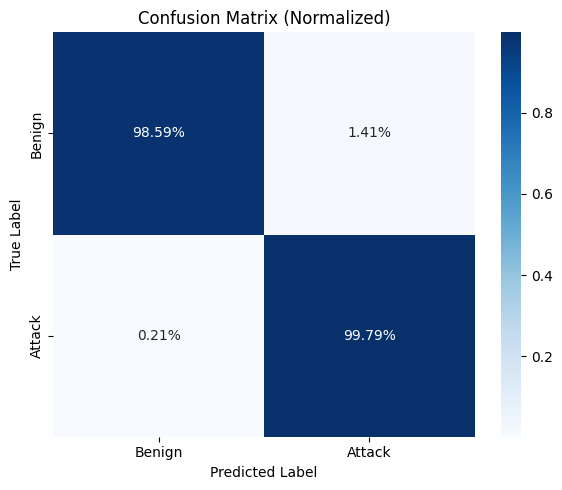

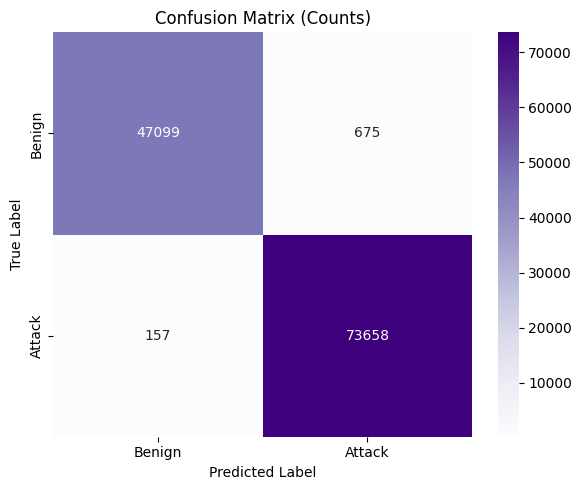

In [ ]:
print("\n Test Set Results:")
print("Adaptive Accuracy:", accuracy_score(y_test_np, y_pred_adaptive))
print("\nAdaptive Classification Report:")
print(classification_report(y_test_np, y_pred_adaptive, target_names=['Benign', 'Attack']))


cm = confusion_matrix(y_test_np, y_pred_adaptive)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Blues",
            xticklabels=['Benign', 'Attack'],
            yticklabels=['Benign', 'Attack'])
plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Raw counts confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=['Benign', 'Attack'],
            yticklabels=['Benign', 'Attack'])
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()